Detection Birds with Bounding Boxes 


we will use the Caltech Birds - 2010 dataset and Tranfer learning

In [1]:
#import
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [2]:
# This functions you will use to draw bounding boxes around the birds in the image.
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
  mage_width = image.shape[1]
  image_height = image.shape[0]
  cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
  draw_bounding_boxes_on_image(image, boxes, color, thickness)
  return image

In [3]:
# visualize the data and the model's predictions.
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
  
  n = len(images)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(n):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bbox = pred_bboxes[i]
      bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
      bboxes_to_plot.append(bbox)
    
    if (len(bboxes) > i):
      bbox = bboxes[i]
      if bboxes_normalized == True:
        bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
      bboxes_to_plot.append(bbox)
    
    img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_to_draw)
    if len(iou) > i :
      color = "black"
      if (iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
# Preprocess and Load the dataset
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

# keep an original image
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

#denormalizes the bounding boxes
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list


In [5]:
# Converts a dataset into numpy arrays of images and boxes.
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)
    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
    if N > 0:
        take_dataset = take_dataset.take(N)
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [6]:
# This will be used for plotting the original images with true and predicted bounding boxes
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete6S6C1H/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incomplete6S6C1H/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


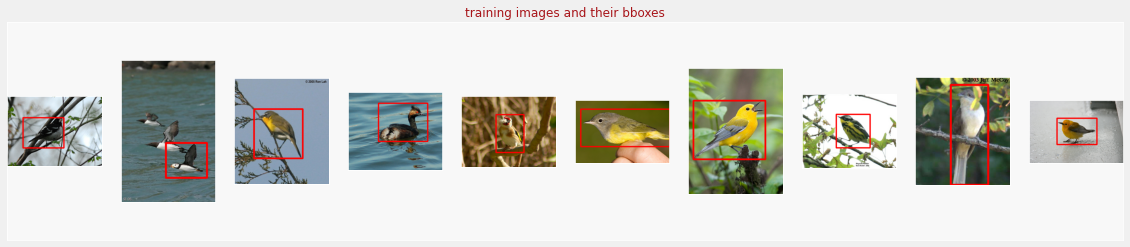

In [7]:
# load data and visualize it with their bounding box label
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()
(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

3033


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


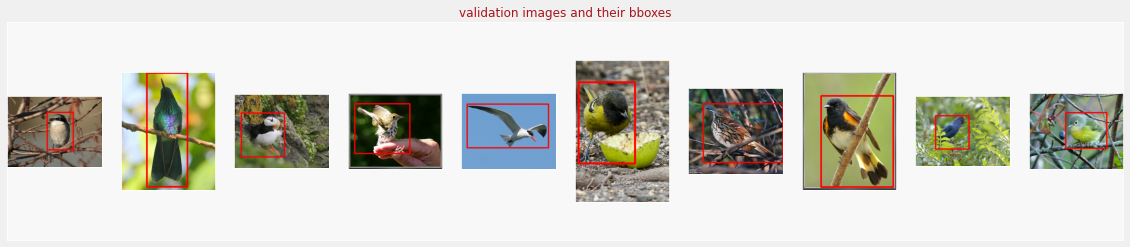

In [8]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True )
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset

visualization_validation_dataset = get_visualization_validation_dataset()
print(len(visualization_validation_dataset))
(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [9]:
#load and prepare data.
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [10]:
#load Model
def feature_extractor(inputs):
  mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224,224,3),
        include_top= False,
        weights="imagenet")
  feature_extractor = mobilenet_model(inputs)
  return feature_extractor

In [11]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features) 
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    return x

In [12]:
def bounding_box_regression(x):    
    bounding_box_regression_output = tf.keras.layers.Dense(4,name="bounding_box")(x)        
    return bounding_box_regression_output

In [13]:
def final_model(inputs):
    # features
    feature_cnn = feature_extractor(inputs)
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    model = tf.keras.Model(inputs=inputs,outputs=bounding_box_output)
      
    return model

In [14]:
def define_and_compile_model():
    # input layer
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    # create the model
    model = final_model(inputs)
    # compile your model
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  loss= "mse")
    return model

In [15]:
model = define_and_compile_model()
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

In [16]:

EPOCHS = 50

BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_images)
print(len(visualization_training_images))
# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_images)
print(len(visualization_validation_images))
# Get the steps per epoch 
steps_per_epoch = (length_of_training_dataset +length_of_validation_dataset)//BATCH_SIZE

# get the validation steps (per epoch) 
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

10
10


In [17]:
print(training_dataset)

history = model.fit(training_dataset,steps_per_epoch=100,validation_data=validation_dataset,
                    validation_steps=1,epochs=8 ) 

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>
Epoch 1/8
100/100 [==============================] - 1268s 13s/step - loss: 0.0953 - val_loss: 0.2214
Epoch 2/8
100/100 [==============================] - 1272s 13s/step - loss: 0.0125 - val_loss: 0.1336
Epoch 3/8
100/100 [==============================] - 1291s 13s/step - loss: 0.0081 - val_loss: 0.1026
Epoch 4/8
100/100 [==============================] - 1306s 13s/step - loss: 0.0062 - val_loss: 0.0808
Epoch 5/8
100/100 [==============================] - 1299s 13s/step - loss: 0.0050 - val_loss: 0.0650
Epoch 6/8
100/100 [==============================] - 1306s 13s/step - loss: 0.0042 - val_loss: 0.0531
Epoch 7/8
100/100 [==============================] - 1295s 13s/step - loss: 0.0039 - val_loss: 0.0442
Epoch 8/8
100/100 [==============================] - 1310s 13s/step - loss: 0.0034 - val_loss: 0.0395


In [18]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

1/1 [==============================] - 3s 3s/step - loss: 0.0395
Loss:  0.039452917873859406


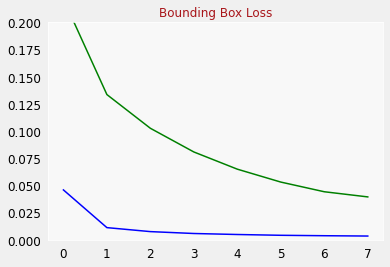

In [19]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [20]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 121
Number of predictions where iou < threshold(0.5): 379


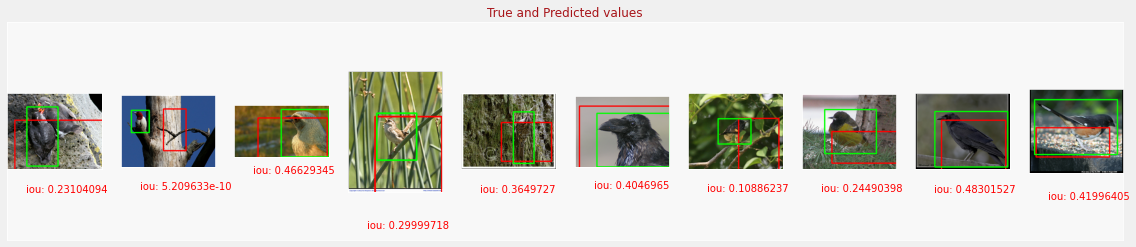

In [21]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)